In [1]:
%matplotlib inline
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import numpy as np
from pathlib import Path
import tensorflow as tf
import os
from PIL import Image

In [2]:
# Define bucket and blob prefix

label_bucket_name = 'catflap-photo-labels'
photo_bucket_name = 'catflap-photos-raw'

In [3]:
# Set up buckets

client = storage.Client()
label_bucket = client.get_bucket(label_bucket_name)
photo_bucket = client.get_bucket(photo_bucket_name)

In [4]:
# Define filepath

filepath = '/home/jupyter/labelled_dataset/'

# Construct ground truth data set from labels

In [5]:
# Get list of blob names

blobs = label_bucket.list_blobs()
blob_list = [blob.name for blob in blobs]
blob_list

['cat_detection_labels - 2020-05-11.csv',
 'cat_detection_labels - 2020-05-12.csv',
 'cat_detection_labels - 2020-05-13.csv',
 'cat_detection_labels - 2020-05-14.csv',
 'cat_detection_labels - 2020-05-15.csv',
 'cat_detection_labels - 2020-05-16.csv',
 'cat_detection_labels - 2020-05-17.csv',
 'cat_detection_labels - 2020-05-18.csv',
 'cat_detection_labels - 2020-05-19.csv',
 'cat_detection_labels - 2020-05-20.csv',
 'cat_detection_labels - 2020-05-21.csv',
 'cat_detection_labels - 2020-05-22.csv',
 'cat_detection_labels - 2020-05-23.csv',
 'cat_detection_labels - 2020-05-24.csv',
 'cat_detection_labels - 2020-05-25.csv',
 'cat_detection_labels - 2020-05-26.csv',
 'cat_detection_labels - 2020-05-27.csv',
 'cat_detection_labels - 2020-05-28.csv',
 'cat_detection_labels - 2020-05-29.csv',
 'cat_detection_labels - 2020-05-30.csv',
 'cat_detection_labels - 2020-05-31.csv']

In [6]:
# Read labels into pandas dataframe

df_list = []
for blob in blob_list:
    labels = pd.read_csv('gs://'+label_bucket_name+'/'+blob)
    df_list += [labels]
label_df = pd.concat(df_list, ignore_index=True, sort=False)

print(label_df.shape)
label_df.head()

(87577, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
0,gs://catflap-photos-raw/2020-05-11_080042.jpg,False,NaN,NaN,NaN,NaN
1,gs://catflap-photos-raw/2020-05-11_080050.jpg,False,NaN,NaN,NaN,NaN
2,gs://catflap-photos-raw/2020-05-11_080058.jpg,False,NaN,NaN,NaN,NaN
3,gs://catflap-photos-raw/2020-05-11_080105.jpg,False,NaN,NaN,NaN,NaN
4,gs://catflap-photos-raw/2020-05-11_080112.jpg,False,NaN,NaN,NaN,NaN


In [7]:
# Get positive examples

positive_examples = label_df[label_df.contains_cat]
positive_examples = positive_examples[positive_examples.in_or_out == 'in']
positive_examples = positive_examples[positive_examples.proportion_of_cat>.8]

print(positive_examples.shape)
positive_examples.head()

(148, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
98,gs://catflap-photos-raw/2020-05-11_081307.jpg,True,in,NaN,NaN,1.0
99,gs://catflap-photos-raw/2020-05-11_081314.jpg,True,in,NaN,NaN,1.0
100,gs://catflap-photos-raw/2020-05-11_081325.jpg,True,in,NaN,NaN,1.0
101,gs://catflap-photos-raw/2020-05-11_081332.jpg,True,in,NaN,NaN,1.0
247,gs://catflap-photos-raw/2020-05-11_083124.jpg,True,in,entering,NaN,1.0


In [8]:
# Get negative examples

negative_to_positive_ratio = 10
number_negative_exampels = negative_to_positive_ratio * len(positive_examples)
negative_examples = label_df[label_df.contains_cat == False].sample(n = number_negative_exampels)

print(negative_examples.shape)
negative_examples.head()

(1480, 6)


,blob_location,contains_cat,in_or_out,entering_or_exiting,seen_through,proportion_of_cat
11393,gs://catflap-photos-raw/2020-05-13_084759.jpg,False,NaN,NaN,NaN,NaN
51050,gs://catflap-photos-raw/2020-05-21_183624.jpg,False,NaN,NaN,NaN,NaN
78887,gs://catflap-photos-raw/2020-05-28_194726.jpg,False,NaN,NaN,NaN,NaN
64031,gs://catflap-photos-raw/2020-05-24_172046.jpg,False,NaN,NaN,NaN,NaN
70242,gs://catflap-photos-raw/2020-05-26_104256.jpg,False,NaN,NaN,NaN,NaN


In [9]:
# Concatenate positive and negative examples

labelled_blobs = pd.concat([positive_examples, negative_examples], ignore_index=True)
labelled_blobs = labelled_blobs[['blob_location','contains_cat']]

print(labelled_blobs.shape)
labelled_blobs.head()

(1628, 2)


,blob_location,contains_cat
0,gs://catflap-photos-raw/2020-05-11_081307.jpg,True
1,gs://catflap-photos-raw/2020-05-11_081314.jpg,True
2,gs://catflap-photos-raw/2020-05-11_081325.jpg,True
3,gs://catflap-photos-raw/2020-05-11_081332.jpg,True
4,gs://catflap-photos-raw/2020-05-11_083124.jpg,True


In [10]:
# Check all blob_locations are unique

assert labelled_blobs.blob_location.nunique() == len(labelled_blobs)

In [11]:
# Check we have the right ratio of positive and negative examples

assert labelled_blobs.contains_cat.sum() * negative_to_positive_ratio == (labelled_blobs.contains_cat==False).sum()

In [12]:
# Extract filename

labelled_blobs['filename'] = labelled_blobs.blob_location.str.split('/').apply(lambda x: x[-1])

labelled_blobs.head()

,blob_location,contains_cat,filename
0,gs://catflap-photos-raw/2020-05-11_081307.jpg,True,2020-05-11_081307.jpg
1,gs://catflap-photos-raw/2020-05-11_081314.jpg,True,2020-05-11_081314.jpg
2,gs://catflap-photos-raw/2020-05-11_081325.jpg,True,2020-05-11_081325.jpg
3,gs://catflap-photos-raw/2020-05-11_081332.jpg,True,2020-05-11_081332.jpg
4,gs://catflap-photos-raw/2020-05-11_083124.jpg,True,2020-05-11_083124.jpg


# Download images to disk from Cloud Storage

In [13]:
# Download images

download_images = False

if download_images:
    for filename in labelled_blobs.filename:

        blob = photo_bucket.blob(filename)
        blob_str = blob.download_to_filename(filepath+filename)

# Read data set from disk

In [14]:
# Read files from disk

filenames = []
dataset = []
for filename in os.listdir(filepath):
    if 'jpg' in filename:
        img = mpimg.imread(filepath+filename)

        filenames += [filename]
        dataset += [img[:,:,0]] # single colour

In [15]:
# Add labels to files loaded from disk

labels_from_disk = pd.DataFrame()
labels_from_disk['filename'] = filenames
labels_from_disk['contains_cat'] = False
labels_from_disk.loc[labels_from_disk[labels_from_disk.filename.isin(labelled_blobs[labelled_blobs.contains_cat].filename)].index,'contains_cat'] = True

print(labels_from_disk.shape)
labels_from_disk.head()

(1551, 2)


,filename,contains_cat
0,2020-05-24_145519.jpg,False
1,2020-05-24_085223.jpg,True
2,2020-05-18_083541.jpg,False
3,2020-05-11_125217.jpg,False
4,2020-05-24_090109.jpg,True


# Create train, validation and test sets

In [16]:
# Split

labels_from_disk['fold'] = 'train'
labels_from_disk.loc[labels_from_disk.sample(frac=.3).index, 'fold'] = 'test'
labels_from_disk.loc[labels_from_disk[labels_from_disk.fold=='train'].sample(frac=.5).index, 'fold'] = 'valid'

labels_from_disk.head()

,filename,contains_cat,fold
0,2020-05-24_145519.jpg,False,valid
1,2020-05-24_085223.jpg,True,valid
2,2020-05-18_083541.jpg,False,valid
3,2020-05-11_125217.jpg,False,train
4,2020-05-24_090109.jpg,True,test


In [17]:
# Convert contains cat from boolean to integer

labels_from_disk['contains_cat_int'] = labels_from_disk.contains_cat.astype('int32')
labels_from_disk.head()

,filename,contains_cat,fold,contains_cat_int
0,2020-05-24_145519.jpg,False,valid,0
1,2020-05-24_085223.jpg,True,valid,1
2,2020-05-18_083541.jpg,False,valid,0
3,2020-05-11_125217.jpg,False,train,0
4,2020-05-24_090109.jpg,True,test,1


In [18]:
# Count each fold

labels_from_disk.groupby(['fold','contains_cat']).filename.count().unstack()

contains_cat,False,True
fold,,
test,423,42
train,492,51
valid,495,48


In [19]:
# Create train, test and validation data frames

train_labels = labels_from_disk[labels_from_disk.fold=='train']
valid_labels = labels_from_disk[labels_from_disk.fold=='valid']
test_labels = labels_from_disk[labels_from_disk.fold=='test']

print(train_labels.shape)
print(valid_labels.shape)
print(test_labels.shape)

(543, 4)
(543, 4)
(465, 4)


In [20]:
# Create dataset variables

train_dataset = np.array([dataset[i] for i in train_labels.index])
valid_dataset = np.array([dataset[i] for i in valid_labels.index])
test_dataset = np.array([dataset[i] for i in test_labels.index])

In [21]:
# Create GIF of positive examples in the training set

training_cat_filepaths = filepath+train_labels[train_labels.contains_cat].filename
train_images = [Image.open(x).resize(size=(80*4,60*4)) for x in training_cat_filepaths]
train_images[0].save('training_photos.gif', save_all=True, append_images=train_images[1:], optimize=True, duration=100, loop=0, dpi=(80,60))

In [22]:
# Create constants

downsample_by = 10

image_height = int(600 / downsample_by)
image_width = int(800 / downsample_by)
n_colours = 1
n_labels = 2

In [23]:
# Downsample pixels

train_dataset = train_dataset[:,::downsample_by,::downsample_by]
test_dataset = test_dataset[:,::downsample_by,::downsample_by]
valid_dataset = valid_dataset[:,::downsample_by,::downsample_by]

# Construct model

In [24]:
# Build model

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(image_height, image_width)),
    tf.keras.layers.Dense(2)
])

In [25]:
# Define loss function

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [26]:
# Compile model

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [27]:
# Train model

model_fit = model.fit(train_dataset, train_labels.contains_cat_int, epochs=100, verbose=0)

In [28]:
# Make predictions and insert into validation data set

valid_labels.loc[:,'prediction'] = np.argmax(model.predict(valid_dataset), axis=-1)

valid_labels.head()

/home/jupyter/.local/share/virtualenvs/cat-detection-DpT3z93U/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyter/.local/share/virtualenvs/cat-detection-DpT3z93U/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,filename,contains_cat,fold,contains_cat_int,prediction
0,2020-05-24_145519.jpg,False,valid,0,0
1,2020-05-24_085223.jpg,True,valid,1,1
2,2020-05-18_083541.jpg,False,valid,0,0
5,2020-05-22_193506.jpg,False,valid,0,0
10,2020-05-24_095904.jpg,False,valid,0,0


In [29]:
# Save model to disk as a tensorflow format SavedModel

model.save('/home/jupyter/logistic_regression_v1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/jupyter/logistic_regression_v1/assets


In [30]:
# Copy SavedModel to Google Cloud Storage bucket

!gsutil cp -r /home/jupyter/logistic_regression_v1 gs://cat-detection-models

Copying file:///home/jupyter/logistic_regression_v1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/logistic_regression_v1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/logistic_regression_v1/variables/variables.index [Content-Type=application/octet-stream]...
- [3 files][167.2 KiB/167.2 KiB]                                                
Operation completed over 3 objects/167.2 KiB.                                    


In [31]:
# Write image to json file

import json
json_instances_dict = {'flatten_input': test_dataset[0,:,:].tolist()}
with open('/home/jupyter/json-instances.json', 'w') as fp:
    json.dump(json_instances_dict, fp)

In [32]:
# Test SavedModel using local json file

!gcloud ai-platform local predict --model-dir /home/jupyter/logistic_regression_v1/ --json-instances /home/jupyter/json-instances.json --framework tensorflow


If the signature defined in the model is not serving_default then you must specify it via --signature-name flag, otherwise the command may fail.
Instructions for updating:
non-resource variables are not supported in the long term
2020-06-02 21:01:22.891474: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-06-02 21:01:22.891522: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-06-02 21:01:22.891649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cat-detection-instance): /proc/driver/nvidia/version does not exist
2020-06-02 21:01:22.891976: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-06-02 21:01:22.901912: I tensorfl

In [33]:
# Compare result to prediction of in-memory model

model.predict(test_dataset[:1,:,:])

array([[-299.3292 ,  367.39664]], dtype=float32)

In [34]:
import sys
sys.version

'3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) \n[GCC 7.3.0]'

In [35]:
tf.__version__

'2.1.0'

In [44]:
# Write image to batch json file

import json
json_instances_dict = {'flatten_input': test_dataset[0,:,:].tolist()}
with open('/home/jupyter/input-data-file.json', 'w') as fp:
    json.dump(json_instances_dict, fp)

In [45]:
# Copy batch json file to Google Cloud Storage bucket

!gsutil cp -r /home/jupyter/input-data-file.json gs://cat-detection-models/

Copying file:///home/jupyter/input-data-file.json [Content-Type=application/json]...
/ [1 files][ 22.2 KiB/ 22.2 KiB]                                                
Operation completed over 1 objects/22.2 KiB.                                     


In [61]:
# Submit prediction job using cloud ai-platform command line tool

!(DATA_FORMAT="text"; \
  INPUT_PATHS='gs://cat-detection-models/input-data-file.json'; \
  OUTPUT_PATH='gs://cat-detection-models/'; \
  MODEL_NAME='logistic_regression_v1'; \
  VERSION_NAME='logistic_regression_v1'; \
  REGION='europe-west2'; \
  now=$(date +"%Y%m%d_%H%M%S"); \
  JOB_NAME="cat_detection_logistic_regression_batch_predict_$now"; \
  MAX_WORKER_COUNT="20"; \
  gcloud ai-platform jobs submit prediction $JOB_NAME --model $MODEL_NAME --input-paths $INPUT_PATHS --output-path $OUTPUT_PATH --region $REGION --data-format $DATA_FORMAT; \
)

Job [cat_detection_logistic_regression_batch_predict_20200602_225031] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe cat_detection_logistic_regression_batch_predict_20200602_225031

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs cat_detection_logistic_regression_batch_predict_20200602_225031
jobId: cat_detection_logistic_regression_batch_predict_20200602_225031
state: QUEUED


# Analyse predictions for validation data set

In [36]:
# Calculate confusion matrix

valid_labels.groupby(['contains_cat_int','prediction']).filename.count().unstack()

prediction,0,1
contains_cat_int,,
0,494,1
1,4,44


In [37]:
# Create columns for each cell in confusion matrix

valid_labels.loc[:,'tp'] = (valid_labels.contains_cat_int==1) & (valid_labels.prediction==1)
valid_labels.loc[:,'fp'] = (valid_labels.contains_cat_int==0) & (valid_labels.prediction==1)
valid_labels.loc[:,'fn'] = (valid_labels.contains_cat_int==1) & (valid_labels.prediction==0)
valid_labels.loc[:,'tn'] = (valid_labels.contains_cat_int==0) & (valid_labels.prediction==0)

valid_labels.head()

/home/jupyter/.local/share/virtualenvs/cat-detection-DpT3z93U/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyter/.local/share/virtualenvs/cat-detection-DpT3z93U/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,filename,contains_cat,fold,contains_cat_int,prediction,tp,fp,fn,tn
0,2020-05-24_145519.jpg,False,valid,0,0,False,False,False,True
1,2020-05-24_085223.jpg,True,valid,1,1,True,False,False,False
2,2020-05-18_083541.jpg,False,valid,0,0,False,False,False,True
5,2020-05-22_193506.jpg,False,valid,0,0,False,False,False,True
10,2020-05-24_095904.jpg,False,valid,0,0,False,False,False,True


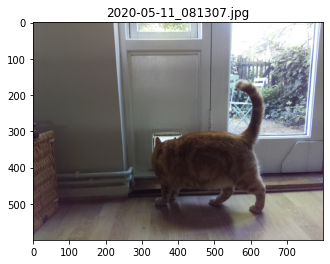

In [38]:
# Plot training set containing Thomas

for blob_name in train_labels[train_labels.contains_cat].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

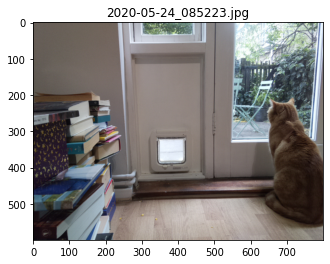

In [39]:
# Plot true positives

for blob_name in valid_labels[valid_labels.tp].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

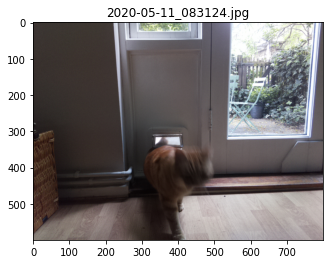

In [40]:
# Plot false negatives

for blob_name in valid_labels[valid_labels.fn].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

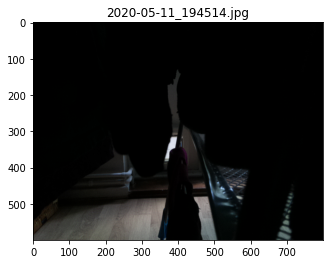

In [41]:
# Plot false positives

for blob_name in valid_labels[valid_labels.fp].iloc[-2:].filename:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    #break